In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
# import os
# import sqlalchemy
# from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
# import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
# import alloc_functions.daily as adf
# import alloc_functions.cleanup as cleaner
# import alloc_functions.mixed as mixed
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib
# import json
from pulp import *

# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')

## Create routes and vehicle duties

### All route distance

In [27]:
cnx = dbh.create_alch_engine()
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
allroutes = pd.read_sql_query(sql_query, con=cnx)
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
allroutes['spec_id'] = allroutes['vehicle_id'].map(vehicle_spec_dict)
allroutes['date'] = allroutes['departure_time'].dt.date
sql_query = "SELECT * FROM t_allocation WHERE allocation_id >= 414 AND vehicle1 IN (101, 102, 103, 104) ORDER BY allocation_id"
allocations = pd.read_sql_query(sql_query, con=cnx)
allocation_ids = allocations['allocation_id'].unique()
sql_query = f"SELECT allocation_id, route_id, allocated_vehicle_id FROM t_route_allocated WHERE allocation_id IN {tuple(allocation_ids)}"
allocated_routes = pd.read_sql_query(sql_query, con=cnx)
allroutes['in_final_allocations'] = allroutes['route_id'].isin(allocated_routes['route_id'])
allroutes = allroutes.merge(allocated_routes, how='left',
                left_on='route_id', right_on='route_id')
selected_v = allocated_routes['allocated_vehicle_id'].unique()
allroutes['selected_v'] = allroutes['vehicle_id'].isin(selected_v)
allroutes['allocated_miles'] = allroutes['distance_miles'] * allroutes['in_final_allocations'].astype(int)
allroutes = allroutes.merge(allocations[['allocation_id', 'site_id']], how='left',
                left_on='allocation_id', right_on='allocation_id')
allocated_routes = allocated_routes.merge(allocations[['allocation_id', 'site_id']], how='left',
                left_on='allocation_id', right_on='allocation_id')

In [28]:
vehicle_distance = allroutes.groupby('vehicle_id').agg({
    'distance_miles': 'sum',
    'departure_time': 'min',
    'arrival_time': 'max',
    'allocated_miles': 'sum',
    'selected_v': 'mean',
    'spec_id': 'mean',
    'site_id': 'first'
})
vehicle_distance['td_covered'] = vehicle_distance['arrival_time'] - vehicle_distance['departure_time']
vehicle_distance['days_covered'] = vehicle_distance['td_covered'] / dt.timedelta(days=1)
vehicle_distance['annual_distance'] = 365*vehicle_distance['distance_miles'] / vehicle_distance['days_covered']
vehicle_distance['annual_distance_alloc'] = 365*vehicle_distance['allocated_miles'] / vehicle_distance['days_covered']

In [32]:
vehicle_distance.groupby('spec_id').agg({
    'departure_time': 'count',
    'distance_miles': 'sum'
}).astype(int)

,departure_time,distance_miles
spec_id,,
0.0,30,95317
100.0,1997,9469667
101.0,346,1320573
102.0,86,362287
103.0,176,970662
104.0,705,5613203


In [47]:
mask = (vehicle_distance['selected_v'] > 0)
vehicle_distance[mask].groupby('spec_id').agg({
    'departure_time': 'count',
    'distance_miles': 'sum'
}).astype(int)

,departure_time,distance_miles
spec_id,,
101.0,341,1311155
102.0,84,361230
103.0,136,858594
104.0,586,4742443


In [53]:
vehicle_distance[mask].groupby('site_id').agg({
    'departure_time': 'count',
    'distance_miles': 'sum'
}).astype(int)

,departure_time,distance_miles
site_id,,
1.0,132,737241
2.0,44,278477
3.0,108,744363
4.0,98,538020
5.0,91,707898
6.0,130,1113271
7.0,106,540812
8.0,80,764140
9.0,73,593721


In [70]:
vehicles_per_site = allocated_routes.groupby('site_id').agg({'allocated_vehicle_id': 'nunique'})
site_dict = ff.get_site_name_dict(2)
vehicles_per_site['site_name'] = vehicles_per_site.index.map(site_dict)
vehicles_per_site.to_csv('sample/hgv2/allsites_num_vehicles_alloc.csv')

In [74]:
hgv_assets = pd.read_csv(r"C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\22-03.SSL.depot_asset_register.MA.02.csv",
                         usecols=['Fleet Reg No', 'spec_id', 'Site'])
mask_specs = hgv_assets['spec_id'] > 100
hgv_assets[mask_specs].groupby('Site')[['spec_id']].count().to_csv('sample/hgv2/allsites_num_vehicles_register.csv')

In [127]:
route_mask = ((allroutes['site_id_start'] == 1) & (allroutes['spec_id'] == 103))
vehicle_distance2 = allroutes.groupby('vehicle_id').agg({
    'distance_miles': 'sum',
})

vehicle_distance2['annual_distance'] = 365*vehicle_distance['distance_miles'] / 77
vehicle_distance2.mean()

distance_miles      5338.835659
annual_distance    25307.467733
dtype: float64

In [119]:
mask = vehicle_distance['site_id'] == 1
vehicle_distance[mask].groupby(['spec_id'])['annual_distance2'].mean()

spec_id
101.0    23244.527626
102.0    24700.777349
103.0    26296.436698
104.0    35249.720695
Name: annual_distance2, dtype: float64

In [120]:
mask = ((vehicle_distance['selected_v'] > 0) & (vehicle_distance['site_id'] == 1))
vehicle_distance[mask].groupby('spec_id')[['annual_distance2', 'annual_distance_alloc']].mean()

,annual_distance2,annual_distance_alloc
spec_id,,
101.0,23244.527626,17751.249616
102.0,24700.777349,21034.579625
103.0,26296.436698,22033.262985
104.0,35249.720695,30850.358795


### Telematics

In [45]:
# sql_query = "SELECT departure_time, arrival_time, vehicle_id, distance_miles FROM t_telematics WHERE run = 44"
# telematics = pd.read_sql_query(sql_query, con=cnx)
# telematics_distance = telematics.groupby('vehicle_id').agg({
#     'departure_time': 'min',
#     'arrival_time': 'max',
#     'distance_miles': 'sum'
# })
# import pickle
# pickle.dump(telematics_distance, open('sample/hgv2/telematics_vehicle_distance.pkl', 'wb'))

import pickle
telematics_distance = pickle.load(open('sample/hgv2/telematics_vehicle_distance.pkl', 'rb'))
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
telematics_distance['spec_id'] = telematics_distance.index.map(vehicle_spec_dict)
telematics_distance['week_appeared'] = telematics_distance['departure_time'].dt.isocalendar().week
telematics_distance['week_last'] = telematics_distance['arrival_time'].dt.isocalendar().week
mask_specs = telematics_distance['spec_id'] > 100
week_appeared = telematics_distance[mask_specs].groupby('week_appeared')['distance_miles'].count()
week_last = telematics_distance[mask_specs].groupby('week_last')['distance_miles'].count()

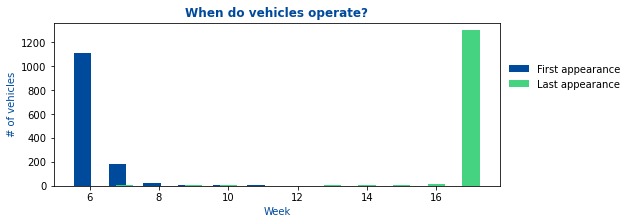

In [46]:
fig, ax = plt.subplots(
    1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    'When do vehicles operate?',
    color=ff.FPS_COLOURS[0], fontweight='bold')
ax.bar(
    x=week_appeared.index-0.2,
    height=week_appeared, width=0.5,
    color=[ff.FPS_COLOURS[0]], label='First appearance')
ax.bar(
    x=week_last.index,
    height=week_last, width=0.5,
    color=[ff.FPS_COLOURS[1]], label='Last appearance')

ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# of vehicles', color=ff.FPS_COLOURS[0])
ax.set_xlabel('Week', color=ff.FPS_COLOURS[0])
# ax.xaxis.set_major_locator(
#     matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
# ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
# n_veh = len(routes['vehicle_id'].unique())
# ax.text(x=len(grouped)+2, y=grouped['route_id'].max()/2,
#         s=f'{n_veh} vehicles in total')
fig.savefig(
    "sample/hgv2/when_vehicles_operate.png",
    bbox_inches="tight", dpi=300)

In [24]:
telematics_distance.groupby('spec_id').agg({
    'departure_time': 'count',
    'distance_miles': 'sum'
}).astype(int)

,departure_time,distance_miles
spec_id,,
0,81,297313
100,2030,10183423
101,352,1382473
102,86,378031
103,197,1209813
104,707,6240908


### Look at vehicle numbers

In [158]:
site_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 20.0]
n_different_vehicles = len(allroutes['vehicle_id'].unique())
n_different_vehicles_goodspec = allroutes[allroutes['spec_id'] > 100]['vehicle_id'].unique()
routes_sites = allroutes['site_id'].isin(site_list)
vehicles_in_sites = allroutes[routes_sites]['vehicle_id'].unique()
vehicles_in_sites_dup = allroutes[routes_sites].groupby(['site_id'])['vehicle_id'].nunique().sum()
print(f"There are {n_different_vehicles} vehicles")
print(f"There are {len(n_different_vehicles_goodspec)} tractors and trailers")
print(f"{len(selected_v)} vehicles are selected for the analysis across all sites")
print(f"There are {len(vehicles_in_sites)} vehicles in the {len(site_list)} sites")
print(f"In practice there are {vehicles_in_sites_dup} vehicles in the 12 sites")

There are 3340 vehicles
There are 1313 tractors and trailers
1147 vehicles are selected for the analysis across all sites
There are 1100 vehicles in the 12 sites
In practice there are 1103 vehicles in the 12 sites


In [164]:
mask_sites = allocated_routes['site_id'].isin(site_list)
allocated_routes[mask_sites].groupby('allocation_id')['allocated_vehicle_id'].nunique().sum()

1103

### Get routes

In [27]:
cnx = dbh.create_alch_engine()
site_dict = ff.get_site_name_dict(2)
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
routes = pd.read_sql_query(sql_query, con=cnx)
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
routes['spec_id'] = routes['vehicle_id'].map(vehicle_spec_dict)
good_specs = {100: 'trailers',
              101: '4x2 rigid',
              102: '6x2 rigid',
              103: '4x2 tractor',
              104: '6x2 tractor'}
routes = routes[routes['spec_id'].isin(good_specs.keys())].copy()
# Create vehicle specification table
# connection, cur = dbh.database_connection('test')
specs = tuple(np.arange(101, 111))
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']

In [28]:
sheet_list = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')
vehicles = sheet_list['vehicle_id'].unique()
vehicle_site_dict = {v: sheet_list[sheet_list['vehicle_id'] == v]['site_id'].values for v in vehicles}
routes['site_ids'] = routes['vehicle_id'].map(vehicle_site_dict)
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False
routes['duration_hours'] = (routes['arrival_time'] - routes['departure_time']).dt.total_seconds()/3600
routes['date'] = routes['departure_time'].dt.date
routes['start_time'] = (routes['departure_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['arrival_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24


for idx in routes.index:
    routes.loc[idx, 'start_right_id'] = ff.right_start_site(
        routes.loc[idx, 'site_id_start'], routes.loc[idx, 'site_ids'])

# for spec in good_specs:
#     spec_routes = routes[routes['spec_id'] == spec]
#     bar_plot_site_ends(spec_routes, site_dict, site, suff=str(spec))

spec_stats = 100*routes.groupby('spec_id')[['same_return']].mean().round(3)
spec_stats['vehicle_type'] = spec_stats.index.map(good_specs)

### Mileage stats and route returns

In [25]:
def q75(x):
    return x.quantile(0.75)
def q99(x):
    return x.quantile(0.99)
route_stats = routes.groupby(
    ['site_id_start', 'spec_id']).agg({
        'distance_miles': ['min', 'mean', 'median', q75, q99, 'max'],
        'client_id': 'count',
        'vehicle_id': 'nunique'})
route_stats['site'] = route_stats.index.get_level_values(0).map(site_dict)
route_stats['vehicle_group'] = route_stats.index.get_level_values(1).map(good_specs)
route_stats.columns = ['min', 'mean', 'median', '75%', '99%', 'max', 'n_routes', 'n_vehicles', 'site', 'vehicle_group']
route_stats.sort_values(by=['site', 'vehicle_group'], inplace=True)
route_stats.to_csv('sample/hgv2/site_mileage.csv', index=False)

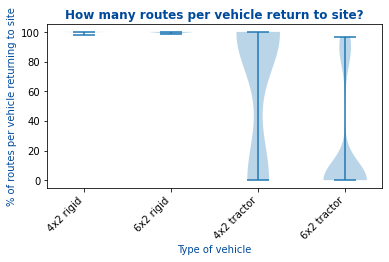

In [26]:
site = 6
site_routes = routes[routes['site_id_start'] == site]
vehicle_return_pc = 100*site_routes.groupby(['spec_id', 'vehicle_id'])['same_return'].mean()
vehicle_high_return = vehicle_return_pc > 95
array_return_pc = []
labels = []
for s in [101, 102, 103, 104]:
    array_return_pc.append(vehicle_return_pc.loc[s].values)
    labels.append(good_specs[s])
ff.violin_plot(array_return_pc, "routes per vehicle",
               site_dict[site], labels=labels, suff="_routes")
# for spec in good_specs:
#     spec_routes = site_routes[(site_routes['spec_id'] == spec)
#                               & (site_routes['site_id_end'] == site)]
    # ff.histo_variable(
    #     spec_routes, 'duration_hours', site_dict[site], upperclip=400,
    #     bins=20, suff=spec, title_text=good_specs[spec])
    # ff.histo_variable(
    #     spec_routes, 'distance_miles', site_dict[site], upperclip=400,
    #     bins=20, suff=spec, title_text=good_specs[spec])

### Daily duties

In [29]:
duty_wait_time = dt.timedelta(hours=4)
routes.sort_values(by=['vehicle_id', 'departure_time'],
                        inplace=True)
routes['prev_wait_time'] = (routes['departure_time'] - routes['arrival_time'].shift(1))
routes['new_vehicle'] = routes['vehicle_id'] != routes['vehicle_id'].shift(1)
routes['new_duties'] = ((routes['new_vehicle']) | (routes['prev_wait_time'] > duty_wait_time))
routes['duty_id'] = routes['new_duties'].cumsum()

daily_duties = routes.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'number_order', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']#
daily_duties['same_return'] = daily_duties['site_id_start'] == daily_duties['site_id_end']
daily_duties['duty_duration'] = (daily_duties['arrival_time'] - daily_duties['departure_time']).dt.total_seconds()/3600

duties_selection_dict = {
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'}

### Site specific

Site: 8 starting with allocation 484
% duties returning to site: 0.9812229176697159
0.7207207207207207
Start with 1656 vehicles showing up in Emerald Park DC,
       1315 have duties starting there
       80 final count


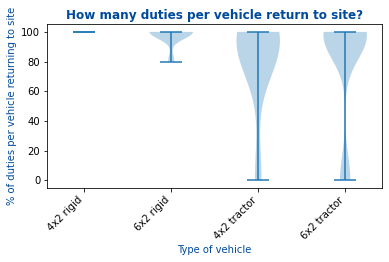

In [118]:
connection, cur = dbh.database_connection('test')
site_list = [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             20,  21,  23, 28]

site = site_list[7] ## CHECK
# first_alloc_id = acf.get_fps_allocation_id(connection, cur) + 1
first_alloc_id = 484
print(f'Site: {site} starting with allocation {first_alloc_id}')
daily_duties_site = daily_duties[(daily_duties['site_id_start'] == site)
                                 & (daily_duties['spec_id'] > 100)]
spec_stats_duty = 100*daily_duties_site.groupby('spec_id')[['same_return']].mean().round(3)
vehicle_return_duty_pc = daily_duties_site.groupby(['spec_id', 'vehicle_id']).agg({'same_return': 'mean', 'date': 'nunique'})
vehicle_high_return = ((vehicle_return_duty_pc['same_return'] > 0.95)
                       & (vehicle_return_duty_pc['date'] > vehicle_return_duty_pc['date']/3))
array_return_pc = []
labels = []
for s in [101, 102, 103, 104]:
    if s in vehicle_return_duty_pc.index.get_level_values(0).unique():
        array_return_pc.append(100*vehicle_return_duty_pc.loc[s, 'same_return'].values)
        labels.append(good_specs[s])
ff.violin_plot(array_return_pc, "duties per vehicle", site_dict[site], labels=labels, suff="_duties")
print(f"% duties returning to site: {daily_duties_site['same_return'].mean()}")
print(vehicle_high_return.mean())

### Filter vehicle duties and routes

vehicles_to_use = vehicle_high_return[vehicle_high_return].index.get_level_values(1)
duties_site_return = daily_duties[(daily_duties['site_id_start'] == site)
                                #   & (daily_duties['site_id_end'] == site)
                                  & (daily_duties['vehicle_id'].isin(vehicles_to_use))].copy()
# histo_variable(duties_site_return, 'duty_duration', site,
#                 upperclip=400, bins=20, suff=spec, title_text=site)
cols_routes = ['site_id_start', 'departure_time', 'arrival_time',
       'vehicle_id', 'distance_miles', 'route_id', 'site_id_end', 'spec_id',
       'duration_hours', 'date', 'start_time', 'end_time', 'prev_wait_time',
       'new_duties', 'duty_id']
routes_vehicle_selection = routes[routes['vehicle_id'].isin(vehicles_to_use)][cols_routes].copy()
duties_vehicle_selection = daily_duties[daily_duties['vehicle_id'].isin(vehicles_to_use)]
n_vehicles_route_start = routes[routes['site_id_start'] == site]['vehicle_id'].nunique()
n_vehicles_duty_start = daily_duties[daily_duties['site_id_start'] == site]['vehicle_id'].nunique()
n_vehicles_site_final = len(vehicles_to_use)
print(
       f"""Start with {n_vehicles_route_start} vehicles showing up in {site_dict[site]},
       {n_vehicles_duty_start} have duties starting there
       {n_vehicles_site_final} final count"""
)

In [116]:
# This creates new breakpoints in the vehicle duties based on the longest break time back on the site

duty_hour_threshold = 25
duty_hour_min = dt.timedelta(hours=24)
long_duties = duties_vehicle_selection[duties_vehicle_selection['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(duties_vehicle_selection))
duty_route_cols = ['site_id_start', 'prev_wait_time', 'new_duties', 'departure_time']
for duty in long_duties[:]:
    duty_routes = routes_vehicle_selection[routes_vehicle_selection['duty_id'] == duty][duty_route_cols]
    elapsed_time = duty_routes['departure_time'] - duty_routes['departure_time'].min()
    time_difference = (elapsed_time - duty_hour_min).dt.total_seconds().abs()
    possible_break_routes = ((duty_routes['site_id_start'] == site)
               & (~duty_routes['new_duties']))
    if possible_break_routes.any():
        break_route = time_difference.loc[possible_break_routes].idxmin()
        routes_vehicle_selection.loc[break_route, 'new_duties'] = True

routes_vehicle_selection['duty_id'] = routes_vehicle_selection['new_duties'].cumsum()

duties_vehicle_selection = routes_vehicle_selection.groupby(['duty_id']).agg(duties_selection_dict)

duties_vehicle_selection.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']

duties_vehicle_selection['duty_duration'] = (duties_vehicle_selection['arrival_time'] - duties_vehicle_selection['departure_time']).dt.total_seconds()/3600
long_duties = duties_vehicle_selection[duties_vehicle_selection['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(duties_vehicle_selection))

duties_vehicle_selection['same_return'] = duties_vehicle_selection['site_id_start'] == duties_vehicle_selection['site_id_end']
daily_duties_site = duties_vehicle_selection[
    (duties_vehicle_selection['site_id_start'] == site)
    & (duties_vehicle_selection['site_id_end'] == site)
    & (duties_vehicle_selection['spec_id'] > 100)]

3 5424
3 5424


### Upload to db

In [41]:
connection, cur = dbh.database_connection('test')
sql_query = """SELECT spec_id, vehicle_model, fuel_type, quoted_range_mile, energy_use, battery_size, charge_power_ac, charge_power_dc
    FROM t_vehicle_specification
    WHERE vehicle_category = 'hgv'
    ORDER BY spec_id"""
hgv_specs = pd.read_sql_query(sql_query, con=cnx, index_col='spec_id')
hgv_drive = hgv_specs['energy_use'].to_dict()
run_id = 186
base_alloc = {
    'run_id': run_id,
    'xmpg_change': 0,
    'allocated': 'c',
    'charger1': 0,
    'charger2': 0,
    'num_charger1': 0,
    'num_charger2': 0,
    'vehicle_pool': '[]',
    'route_table': 't_route_master',
    'xmpg': 1,
    'allocation_score': 0,
    'vcategory': 'Fossil Fuel',
    'overnight_error': 0,
    'schedule_charge': 2,
    'source': 1
}

for i in range(4):
    spec = 101 + i
    allocation_id = first_alloc_id + i

    duties_spec = daily_duties_site[daily_duties_site['spec_id'] == spec]
    if len(duties_spec) > 0:
        cols_routes = ['duty_id', 'route_id', 'date', 'spec_id', 'distance_miles', 'vehicle_id']
        routes_spec = routes_vehicle_selection[routes_vehicle_selection['duty_id'].isin(duties_spec.index)][cols_routes]
        # routes_spec.reset_index(inplace=True)
        routes_spec.columns = ['duty_id', 'route_id', 'date', 'allocated_spec_id', 'distance_miles', 'allocated_vehicle_id']
        routes_spec['allocation_id'] = allocation_id
        routes_spec['shift'] = 1
        routes_spec['diesel_fuel_consumption'] = routes_spec['distance_miles'] * hgv_drive[spec]
        routes_spec.drop(columns=['distance_miles'], inplace=True)
        spec_alloc = {
            'allocation_id': allocation_id,
            'site_id': site,
            'start_date': str(routes_spec['date'].min()),
            'end_date': str(routes_spec['date'].max() + dt.timedelta(days=1)),
            'vehicle1': spec,
            'vehicle2': spec,
            'num_r': len(routes_spec),
            'num_v': len(routes_spec['allocated_vehicle_id'].unique()),
            'num_v_final': len(routes_spec['allocated_vehicle_id'].unique()),
            'num_vehicle1': len(routes_spec['allocated_vehicle_id'].unique()),
            'num_vehicle2': 0,
            'n_duties': len(duties_spec)
        }
        alloc = {**base_alloc, **spec_alloc}
        ff.upload_dict_to_db(alloc, connection, cur)
        dbh.upload_table(routes_spec, 't_route_allocated')
        print(f"Finished alloc {allocation_id} with spec {spec}")

2022-06-15 14:08:09|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 572 with spec 101


2022-06-15 14:08:10|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 573 with spec 102


2022-06-15 14:08:12|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 574 with spec 103


2022-06-15 14:08:15|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 575 with spec 104


## Feasibility Analysis

### Allocation

In [2]:
specs = (101, 102, 103, 104, 111, 112, 113, 114)
site_list = [1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0]
connection, cur = dbh.database_connection('test')
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']

In [3]:
first_alloc_id = 424
first_ev_alloc = acf.get_fps_allocation_id(connection, cur) + 1

ev_allocation_dict = {
    # 111: [first_alloc_id, first_ev_alloc, 101],
    112: [first_alloc_id + 1, first_ev_alloc + 1, 102],
    # 113: [first_alloc_id + 2, first_ev_alloc + 2, 103],
    # 114: [first_alloc_id + 3, first_ev_alloc + 3, 104],
}
for ev_spec in ev_allocation_dict.keys():
    allocation, new_allocation = ev_allocation_dict[ev_spec][0], ev_allocation_dict[ev_spec][1]
    diesel_spec = ev_allocation_dict[ev_spec][2]
    try:
        alloc = ff.find_allocation(allocation)
        assert diesel_spec == alloc['vehicle1'], f"Wrong allocation ID, spec {alloc['vehicle1']} != {diesel_spec}"
        routes_spec, grouped_spec = ff.allocation_grouping(
            alloc,
            vehicle_specifications.loc[ev_spec, 'energy_use'],
            vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
            vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
            connection, cur)
        ff.calculate_feasibility(
            grouped_spec,
            vehicle_specifications.loc[ev_spec, 'quoted_range_mile'])
        ev_vehicle_map = ff.ev_feasibility_dict(grouped_spec, ev_spec)
        grouped_spec['allocated_spec_id'] = grouped_spec['allocated_vehicle_id'].map(ev_vehicle_map)
        routes_spec['allocated_spec_id'] = routes_spec['allocated_vehicle_id'].map(ev_vehicle_map)
        ff.upload_ev_routes(routes_spec,
                        vehicle_specifications['kwh_mile'].to_dict(),
                        vehicle_specifications['diesel_l_mile'].to_dict(),
                        new_allocation)
        veh1_ids = [key for key in ev_vehicle_map.keys()
            if ev_vehicle_map[key] == ev_spec]
        number_dc_max = grouped_spec.groupby('date').sum()['feasible_withdc'].max()
        number_dc = min(number_dc_max, len(veh1_ids))
        feasibility_count = grouped_spec[['feasible_nois', 'feasible_withac', 'feasible_withdc', 'unfeasible_withdc']].sum()
        new_alloc = ff.upload_new_allocation(alloc, new_allocation, routes_spec, ev_vehicle_map,
                                        vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
                                        vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
                                        number_dc, feasibility_count, connection, cur)
        print(f"Finished alloc {new_allocation} with spec {ev_spec}")
    except Exception as e:
        print(f"Not possible to do allocation {allocation} - {new_allocation}")
        print(e)

2022-06-28 10:15:50|DEBUG|controller.py(50)|get_fps_allocation_id|reading last allocation ID
2022-06-28 10:15:55|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 630 with spec 112


In [8]:
sql_query = "SELECT allocation_id FROM t_allocation WHERE allocation_id >= 590 ORDER BY allocation_id"
cur.execute(sql_query)
connection.commit()
allocations = cur.fetchall()
alloc_list = [alloc[0] for alloc in allocations]
print(alloc_list)

### Sumary

In [8]:
### Look at summary of allocations
cnx = dbh.create_alch_engine()
site_dict = ff.get_site_name_dict(2)
sql_query = f"SELECT * FROM t_allocation WHERE allocation_id >= 590"
allocation_df = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
# sql_query = f"SELECT * FROM t_allocation WHERE allocation_id IN (418, 419, 420, 421, 422, 423)"
# allocation_df2 = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
# allocation_df = pd.concat([allocation_df1, allocation_df2])
allocation_df.drop(columns=[
    'run_id', 'vehicle_pool', 'allocated', 'xmpg_change', 'xmpg', 'overnight_error', 'schedule_charge',
    'preliminary_tco_lease', 'preliminary_tco_purchase', 'source', 'start_date', 'end_date', 'cap_vehicles',
    'num_v', 'route_table', 'allocation_score'], inplace=True)
# allocation_df.drop(np.arange(494, 504), inplace=True)
allocation_df['site_name'] = allocation_df['site_id'].map(site_dict)
allocation_df.sort_index(inplace=True)
allocation_df['ev_conversion_pc'] = (100*allocation_df['num_vehicle1'] / allocation_df['num_v_final']).round(1)
specs = tuple(np.arange(101, 115))
vehicle_specifications = ff.find_vehicle_spec(specs)
veh_name_dict = (vehicle_specifications['vehicle_model'] + ' ' + vehicle_specifications['fuel_type']).to_dict()
allocation_df['vehicle_group'] = allocation_df['vehicle1'].map(veh_name_dict)
# allocation_df.to_csv('sample/hgv2/allocation_table_othersites_withname.csv')

In [9]:
allocation_df

,site_id,charger1,charger2,vehicle1,vehicle2,num_r,num_v_final,num_vehicle1,num_vehicle2,num_charger1,...,vcategory,original_allocation,n_duties,n_feas_nois,n_feas_withis,n_unfeas,n_r_rem,site_name,ev_conversion_pc,vehicle_group
allocation_id,,,,,,,,,,,,,,,,,,,,,
590,1,22,150,111,101,1050,8,8,0,8,...,electric,414,716,716,0,0,0,Waltham Point DC,100.0,Rigid 4x2 electric
591,1,43,250,112,102,1539,10,10,0,10,...,electric,415,938,938,0,0,0,Waltham Point DC,100.0,Rigid 6x2 electric
592,1,43,250,113,103,7602,41,41,0,37,...,electric,416,2777,2775,2,0,0,Waltham Point DC,100.0,Tractor 4x2 electric
593,1,43,250,114,104,15600,73,73,0,68,...,electric,417,5161,5129,29,3,0,Waltham Point DC,100.0,Tractor 6x2 electric
594,2,22,150,111,101,248,5,5,0,5,...,electric,434,232,232,0,0,0,Northampton DC,100.0,Rigid 4x2 electric
595,2,43,250,112,102,48,1,1,0,1,...,electric,435,46,46,0,0,0,Northampton DC,100.0,Rigid 6x2 electric
596,2,43,250,113,103,856,7,7,0,6,...,electric,436,374,370,4,0,0,Northampton DC,100.0,Tractor 4x2 electric
597,2,43,250,114,104,5199,31,31,0,28,...,electric,437,1881,1856,23,2,0,Northampton DC,100.0,Tractor 6x2 electric
598,3,22,150,111,101,857,14,14,0,14,...,electric,444,841,841,0,0,0,Basingstoke DC,100.0,Rigid 4x2 electric


In [10]:
conversion_pc_table = allocation_df.set_index(['site_name', 'vehicle_group'])['ev_conversion_pc'].unstack()
conversion_pc_table.to_csv('sample/hgv2/conversion_pc_othersites.csv')

### Feasibility plots

In [ ]:
sql_query = f"SELECT * FROM t_allocation WHERE run_id = 185 ORDER BY allocation_id"
allocation_table = pd.read_sql_query(sql_query, con=cnx)
allocation_table['allocation_id'].values

array([424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 466, 467, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
       480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492,
       493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
       506, 507, 508, 509, 510, 511, 512, 513, 516, 517, 520, 521, 522,
       523, 527, 531, 534, 535, 536, 538, 539, 540, 542, 543, 544, 545,
       546, 547, 548, 549, 550, 551, 552, 553, 557, 561, 567, 571],
      dtype=int64)

In [ ]:
allocation_table['site_id'].unique()

array([ 6,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 20, 21, 23],
      dtype=int64)

In [ ]:
cnx = dbh.create_alch_engine()
sql_query = """SELECT allocation_id, charger1, charger2, vehicle1, vehicle2,
    num_vehicle1, num_vehicle2, num_r, xmpg,
    n_duties, n_feas_nois, n_feas_withis, n_unfeas, n_r_rem
    FROM t_allocation
    WHERE allocation_id >= 414"""
allocation_table = pd.read_sql_query(sql_query, con=cnx)
allocation_tuple = tuple(allocation_table['allocation_id'].values)
sql_query = f"SELECT scenario_id, allocation_id, smart_charging, num_charger1, num_charger2 FROM t_charging_scenarios WHERE allocation_id IN {allocation_tuple}"
scenarios = pd.read_sql_query(sql_query, con=cnx)
scenarios = scenarios.merge(allocation_table, how='left', left_on='allocation_id', right_on='allocation_id')
scenarios.sort_values(by='allocation_id', inplace=True)
scenarios = scenarios.merge(vehicle_specifications, how='left', left_on='vehicle1', right_on='spec_id')
scenarios['total_vehicles'] = scenarios['num_vehicle1'] + scenarios['num_vehicle2']
scenarios.set_index('scenario_id', inplace=True)
scenarios['good_scenario'] = False
scenarios.loc[[510, 511, 512, 513, 516, 517], 'good_scenario'] = True
scenarios['non_diversified_load'] = (scenarios['num_charger1'] * scenarios['charger1']
                                     + scenarios['num_charger2'] * scenarios['charger2'])
# scenarios.to_csv('sample/hgv2/scenarios.csv')

In [ ]:
scenarios[['allocation_id', 'n_duties', 'n_feas_nois', 'n_feas_withis', 'n_unfeas', 'n_r_rem',
           'vehicle_model', 'fuel_type', 'num_vehicle1', 'total_vehicles']]

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 3))
allocations = [418, 419, 420, 421]
group = 'electric'
# allocations = [420, 422, 423]
# group = '4x2tractor'


cols = ['n_feas_nois', 'n_feas_withis', 'n_unfeas', 'n_duties', 'num_vehicle1', 'total_vehicles']
scenarios_vehicle = scenarios[scenarios['allocation_id'].isin(allocations)][cols].values
xlabels = scenarios[scenarios['allocation_id'].isin(allocations)]['vehicle_model'].values
N = len(xlabels)
ax.bar(x = xlabels,
    height=scenarios_vehicle[:, 0]*100/scenarios_vehicle[:, 3],
    width=0.5,
    color=[fps_colours[0]], label='Feasible without daytime charging')
ax.bar(x = xlabels,
    height=scenarios_vehicle[:, 1]*100/scenarios_vehicle[:, 3],
    bottom=scenarios_vehicle[:, 0]*100/scenarios_vehicle[:, 3],
    width=0.5,
    color=[fps_colours[1]], label='Feasible with daytime charging')
ax.bar(x = xlabels,
    height=scenarios_vehicle[:, 2]*100/scenarios_vehicle[:, 3],
    width=0.5,
    bottom=(scenarios_vehicle[:, 0] + scenarios_vehicle[:, 1])*100/scenarios_vehicle[:, 3],
    color=[fps_colours[2]], label='Unfeasible')
ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.set_xlabel('Vehicle Group', color=fps_colours[0])
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(N)))
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.set_ylabel(r'% of Vehicle-duties', color=fps_colours[0])
for i in range(N):
    ax.text(i-0.3, -70,
            f"{scenarios_vehicle[i, 4]} of {scenarios_vehicle[i, 5]} substituted")
ax.set_title(
    f"EV feasibility for each vehicle group",
    color=fps_colours[0], fontweight='bold', y=1.12)
fig.savefig(
    f"sample/hgv2/feasibility_alloc{group}.png",
    bbox_inches="tight", dpi=300)

### Copy allocation table

In [ ]:
allocation_table = pd.read_csv(r'sample\hgv2\allocation_table_other_sites.csv')
allocation_table.sort_values(by='allocation_id', inplace=True)
allocation_table.set_index('allocation_id', inplace=True)
connection, cur = dbh.database_connection('test')
for allocation_id in allocation_table.index[:]:
    n_charger2 = allocation_table.loc[allocation_id, 'num_charger2']
    n_charger1 = allocation_table.loc[allocation_id, 'num_vehicle1'] - n_charger2
    sql_query = f"""UPDATE t_allocation SET num_charger2 = {n_charger2}, num_charger1 = {n_charger1}
        WHERE allocation_id = {allocation_id}"""
    cur.execute(sql_query)
    connection.commit()


## Charging

In [12]:
# Create scenario/allocation table
cnx = dbh.create_alch_engine()
sql_query = "SELECT * FROM t_allocation WHERE allocation_id >= 590 ORDER BY allocation_id"
alloc_df = pd.read_sql_query(sql_query, con=cnx)
sql_query = "SELECT * FROM t_charging_scenarios WHERE allocation_id >= 590"
scen_df = pd.read_sql_query(sql_query, con=cnx)
scen_df = scen_df.merge(alloc_df, how='left', left_on='allocation_id', right_on='allocation_id')
# Fill in names and categories
site_dict = ff.get_site_name_dict(2)
scen_df['site_name'] = scen_df['site_id'].map(site_dict)
specs = tuple(np.arange(101, 115))
vehicle_specifications = ff.find_vehicle_spec(specs)
veh_name_dict = (vehicle_specifications['vehicle_model'] + ' ' + vehicle_specifications['fuel_type']).to_dict()
scen_df['vehicle_group'] = scen_df['vehicle1'].map(veh_name_dict)
# # Compare number of chargers (and fix in t_charging_scenarios)
# scen_df['diesel'] = scen_df['vcategory'] == 'Fossil Fuel'
# scen_df.loc[scen_df['diesel'], ['num_charger1_x', 'num_charger2_x']] = 0
# cols_numbers = ['num_charger1_x', 'num_charger1_y', 'num_charger2_x', 'num_charger2_y', 'num_vehicle1', 'num_vehicle2', 'num_charger1','num_charger2']
# scen_df['num_charger2'] = scen_df['num_charger2_x'].clip(upper=scen_df['num_vehicle1'])
# scen_df['num_charger1'] = scen_df['num_vehicle1'] - scen_df['num_charger2']
# scen_df.loc[scen_df['diesel'], ['num_charger1', 'num_charger2']] = 0
# scen_df.dropna(subset=['num_vehicle1'], inplace=True)
scen_df.set_index('scenario_id', inplace=True)
# # Find if any EV case is missing charge schedule
# scen_df[(~scen_df['diesel']) & (scen_df['num_vehicle1'] > 0)].sort_values(by='output_kwh')
# mask_fix_chargers = (scen_df[['num_charger1_x', 'num_charger2_x']].values != scen_df[['num_charger1', 'num_charger2']].values).any(axis=1)
# scenarios_to_fix = scen_df.loc[mask_fix_chargers].index.values
# for scen in scenarios_to_fix:
#     sql_query = f"""UPDATE t_charging_scenarios
#         SET num_charger1 = {scen_df.loc[scen, 'num_charger1']},
#         num_charger2 = {scen_df.loc[scen, 'num_charger2']}
#         WHERE scenario_id = {scen}"""
    # cur.execute(sql_query)
    # connection.commit()
# Export into Jin's format

In [13]:
# cols1 = ['allocation_id', 'site_name', 'vehicle_group', 'site_id', 'vehicle1', 'num_charger1', 'num_charger2', 'num_vehicle1', 'timeout_days', 'output_kwh']
cols2 = ['allocation_id', 'site_name', 'vehicle_group', 'site_id', 'vehicle1', 'num_charger1_x', 'num_charger2_x', 'num_vehicle1', 'timeout_days', 'output_kwh']
scen_df[cols2].to_csv('sample/hgv2/scenarios_for_jin_mighty.csv')